# Tracking how often mice visit leaf/end nodes

In [1]:
# Imports
from __future__ import print_function
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import sys

module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Some lists of nicknames for mice
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
AllNames=RewNames+UnrewNames
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze

In [3]:
# List number of bouts for each animal
print('mouse  bouts')
to=0
max_bouts = 0
for nickname in AllNames:
    tf = LoadTraj(nickname+'-tf')
    print(nickname+'     ',len(tf.no))
    
    if len(tf.no) > max_bouts:
        max_bouts = len(tf.no)
        
    to+=len(tf.no)
print('Total  ',to)

mouse  bouts
B1      104
B2      166
B3      147
B4      238
C1      173
C3      339
C6      150
C7      135
C8      164
C9      127
B5      245
B6      223
B7      204
D3      245
D4      319
D5      180
D6      59
D7      150
D8      109
D9      102
Total   3579


In [4]:
# define cell numbers of end/leaf nodes
lv6_nodes = list(range(63,127))
lv5_nodes = list(range(31,63))
lv4_nodes = list(range(15,31))
lv3_nodes = list(range(7,15))
lv2_nodes = list(range(3,7))
lv1_nodes = list(range(1,3))
lv0_nodes = list(range(0,1))
lvl_dict = {0:lv0_nodes, 1:lv1_nodes, 2:lv2_nodes, 3:lv3_nodes, 4:lv4_nodes, 5:lv5_nodes, 6:lv6_nodes}

In [5]:
# Generating a 'visits' dictionary with data about target level nodes
def gen_visit_table(end_nodes):
    '''
    visits[nickname][bout][node]: tallies number of times an end node was visited 
                                  (a valid visit is when the mouse had not already been at the node in the previous frame)
    visits[nickname][bout][total]: tallies number of times all target nodes were visited in the specific bout
    '''
    
    visits = {}
    for nickname in AllNames:

        # Loading mouse trajectory
        tf = LoadTraj(nickname+'-tf')

        # Initializing end node visit dictionary
        visits[nickname] = {}

        for bout, node_array in enumerate(tf.no[2:]):
            visits[nickname][bout] = {}
            prior_node = 0

            for node in end_nodes:
                visits[nickname][bout][node] = 0

            for node,frame in node_array:           
                # checking if the node visited in the current frame is an end node
                if node in end_nodes and node != prior_node:
                    visits[nickname][bout][node] += 1

                # keeping track of the mostly recently visited node
                prior_node = node
                
            visits[nickname][bout]['total'] = np.sum(np.asarray(list(visits[nickname][bout].values())))
    return visits

## Select results for output

In [6]:
# Create a table to output based on 'visits' dictionary
def f(bout,lvl):
    
    boutID = bout - 1
    
    # Select list of nodes to track based on level
    end_nodes = lvl_dict[lvl]
    print('Node list: ', end_nodes)
    
    visits = gen_visit_table(end_nodes)

    # Initialize new end node visit dictionary for the selected bout
    visits_bout = {}
    for nickname in AllNames:
        visits_bout[nickname] = {}
        for node in end_nodes:
            try:
                visits_bout[nickname][node] = visits[nickname][boutID][node]
            except:
                visits_bout[nickname][node] = np.nan

    # Create a new dataframe
    df = pd.DataFrame(visits_bout)

    # Print the output
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    print('\nLevel %i nodes visited during bout %i' %(lvl, bout))
    
    return df

In [7]:
# Creating some summary statistics specific to the target level nodes
def gen_summary(lvl):
    '''
    summary[nickname]['None']: % of bouts where NO end nodes were visited
    summary[nickname]['Once']: % of bouts where there was at most ONE visit to any end node
    summary[nickname]['Multiple']: % of bouts where there was at least TWO visits to any end node
    
    summary_bouts: same as 'summary' except with a list of corresponding bouts instead of percentages
    '''

    # Select list of nodes to track based on level
    end_nodes = lvl_dict[lvl]
    print('Node list: ', end_nodes)
    
    visits = gen_visit_table(end_nodes)
    
    summary = {}
    summary_bouts = {}
    for nickname in AllNames:
        summary[nickname] = {}
        summary[nickname]['None'] = 0
        summary[nickname]['Once'] = 0
        summary[nickname]['Multiple'] = 0
        summary_bouts[nickname] = {}
        summary_bouts[nickname]['None'] = []
        summary_bouts[nickname]['Once'] = []
        summary_bouts[nickname]['Multiple'] = []
        total_bouts = len(visits[nickname].keys())

        # Calculating % of bouts where NO end nodes were visited
        no_end_nodes = 0
        for bout in visits[nickname].keys():
            total_visits = visits[nickname][bout]['total']

            if total_visits == 0:
                no_end_nodes += 1
                summary_bouts[nickname]['None'].extend([bout+1])

        summary[nickname]['None'] = np.round(no_end_nodes * 100 / total_bouts)

        # Calculating % of bouts where there was at most only ONE visit to any end node
        one_end_node = 0
        multiple_end_node = 0
        for bout in visits[nickname].keys():
            total_visits = np.sum(np.asarray(list(visits[nickname][bout].values())))

            if total_visits != 0:
                one_visit = True
                for node in visits[nickname][bout]:

                    # Checking if an end node has been visited multiple times
                    if visits[nickname][bout][node] > 1:
                        one_visit = False

                if one_visit:
                    one_end_node += 1
                    summary_bouts[nickname]['Once'].extend([bout+1])
                elif not one_visit:
                    multiple_end_node += 1
                    summary_bouts[nickname]['Multiple'].extend([bout+1])

                summary[nickname]['Once'] = np.round(one_end_node * 100 / total_bouts)
                summary[nickname]['Multiple'] = np.round(multiple_end_node * 100 / total_bouts)
                
    return visits, summary, summary_bouts

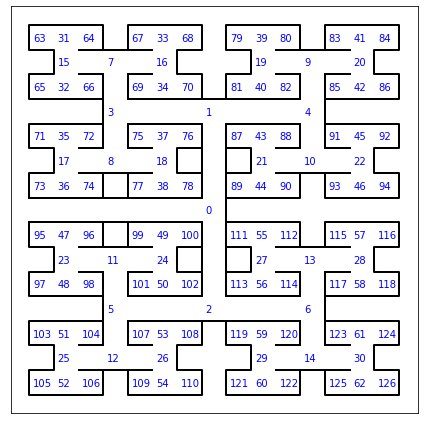

In [8]:
# Draw maze with node numbers
ma=NewMaze(6)
PlotMazeNodes(ma,figsize=6)

In [9]:
# Interative table to look at the number of times a specific level node was visited by each mouse for a specific bout
set_bout = 24
interact(f, bout=widgets.IntSlider(min=1, max=max_bouts, step=1, value=set_bout), 
         lvl = widgets.IntSlider(min=0, max=6, step=1, value=1));

interactive(children=(IntSlider(value=24, description='bout', max=339, min=1), IntSlider(value=1, description=…

In [10]:
# Creating a plot of the number of times target level nodes were visited per bout for each mouse
def gen_nodefreq_plot(visits, names):
    plt.figure(figsize=(20,10))
    for nickname in names:
        x_vals = np.arange(1,len(visits[nickname])+1)
        y_vals = [visits[nickname][bout]['total'] for bout in np.arange(len(visits[nickname]))]
        plt.plot(x_vals, y_vals, label=nickname)

    plt.xlabel('Bouts')
    plt.ylabel('Total target nodes visited')
    plt.title('Level %i nodes visit frequency per bout' %(lvl))
    plt.legend()

Node list:  [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


 None: % of bouts where NO end nodes were visited
 Once: % of bouts where any end node was visited ONCE at most
 Multiple: % of bouts where any end node was visited MORE than ONCE


,B1,B2,B3,B4,C1,C3,C6,C7,C8,C9,B5,B6,B7,D3,D4,D5,D6,D7,D8,D9
None,20.0,3.0,43.0,17.0,6.0,13.0,12.0,11.0,1.0,2.0,31.0,41.0,45.0,46.0,43.0,8.0,100.0,31.0,12.0,17.0
Once,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
Multiple,80.0,96.0,57.0,83.0,94.0,87.0,88.0,89.0,98.0,98.0,68.0,58.0,53.0,54.0,56.0,91.0,0.0,69.0,88.0,83.0


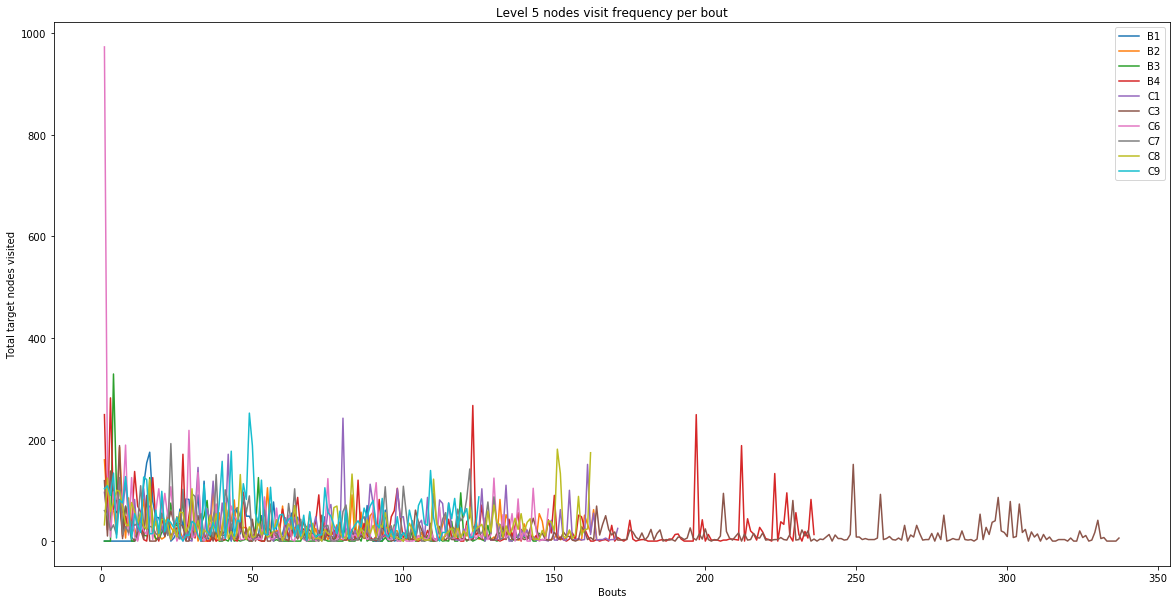

In [11]:
# Generate frequency of level node visits per bout plot
lvl = 5
names = RewNames  # AllNames, RewNames, UnrewNames
visits, summary, summary_bouts = gen_summary(lvl)
gen_nodefreq_plot(visits, names)

# Output summary statistics about the frequency of level node visits
df_summary = pd.DataFrame(summary)
print("\n\n None: % of bouts where NO end nodes were visited" 
       "\n Once: % of bouts where any end node was visited ONCE at most"
       "\n Multiple: % of bouts where any end node was visited MORE than ONCE")
df_summary

In [12]:
# Converting visits dictionary to 2D array: mouse x bouts....excluding mouse D6 that didn't visit any endnodes
visits_array = np.zeros((len(AllNames), max_bouts))
for nid, nickname in enumerate(AllNames):
    for bout in visits[nickname]:
        visits_array[nid,bout] = visits[nickname][bout]['total']

# Calculating the expected, min and max number of end nodes
total_endnodes_bout = np.sum(visits_array, axis=0)

expected_nodes = np.zeros(max_bouts)
min_nodes = np.zeros(max_bouts)
max_nodes = np.zeros(max_bouts)

for bout in np.arange(max_bouts):
    expected_nodes[bout] = np.sum(np.multiply( visits_array[:,bout], 
                                              np.divide(visits_array[:,bout], total_endnodes_bout[bout]) ))
    min_nodes[bout] = np.min(visits_array[:,bout])
    max_nodes[bout] = np.max(visits_array[:,bout])

C:\Users\kdilh\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Text(0.5, 1.0, 'All Mice')

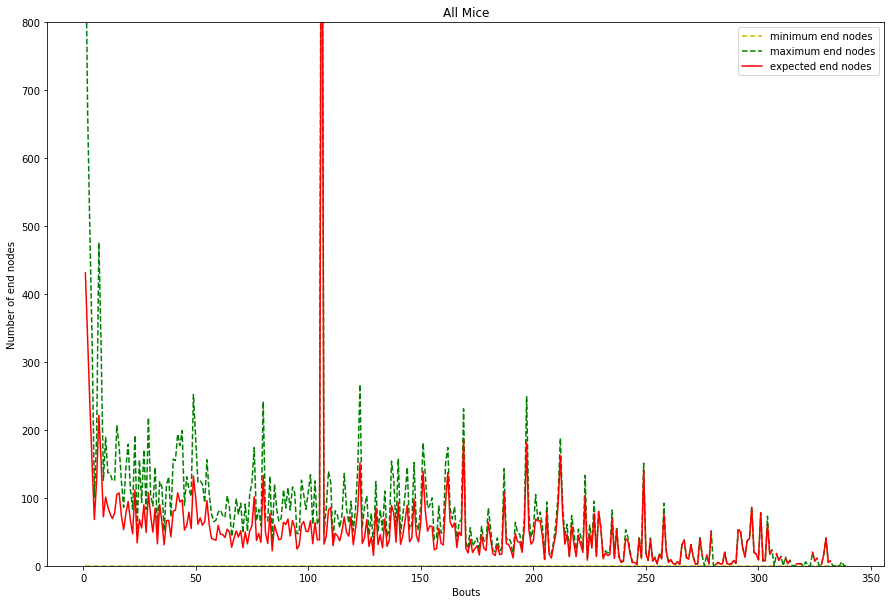

In [13]:
# Plotting expected number, min and max of end-nodes visited
plt.figure(figsize=(15,10))
plt.plot(np.arange(1,max_bouts+1),min_nodes, '--y', label='minimum end nodes')
plt.plot(np.arange(1,max_bouts+1),max_nodes, '--g', label='maximum end nodes')
plt.plot(np.arange(1,max_bouts+1),expected_nodes, 'r', label='expected end nodes')
plt.ylim([0,800])
plt.ylabel('Number of end nodes')
plt.xlabel('Bouts')
plt.legend()
plt.title('All Mice')

## Plot 2: Behavior after  visiting the first end node

In [14]:
'''
The goal is to understand how an animal behaves after visiting the first end node. How close to home does it go
and if it doesn't exit the maze right away, how deep into the maze does it explore afterwards?
The path segments of interest are those which increase or decrease in maze depth.

frEN: (20,3) array with columns for all mice and the first row holds first end node visited.
      The second row holds the shallowest node level visited soon after first end node visit. 
      The third row holds a possible deepest node level visited after exploring again from the shallow node
'''

frEN = np.zeros((3,20))

for mouseID, nickname in enumerate(AllNames):
    tf = LoadTraj(nickname+'-tf')
    frEN_visit = False
    shNlvl = 6
    dNlvl = 0
    for bout in tf.no:
        if not frEN_visit:
            for node in bout[:,0]:
                if node in lv6_nodes and not frEN_visit:
                    frEN[ 0, mouseID] = node
                    frEN_visit = True   
                
                if frEN_visit:
                    # If first end node has already been visited check for the shallowest node
                    for level, lvlnodes in lvl_dict.items():
                        if node in lvlnodes:
                            postENlvl = level
                    if postENlvl < shNlvl:
                        shNlvl = postENlvl
                    elif postENlvl >= shNlvl:
                        if postENlvl > dNlvl:
                            dNlvl = postENlvl
                        else:
                            break
            frEN[ 1, mouseID] = shNlvl
            frEN[ 2, mouseID] = dNlvl
        elif frEN_visit:
            break
    
    if not frEN_visit:
        frEN[ 1, mouseID] = 0

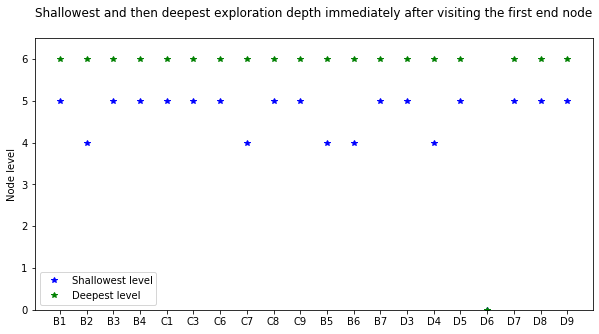

In [15]:
# Plot figure for shallowest and deepest node level explored immediately after the first end node visit
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,21), frEN[1,:], '*b', label='Shallowest level')
plt.plot(np.arange(1,21), frEN[2,:], '*g', label='Deepest level')
plt.xticks(ticks=np.arange(1,21), labels=AllNames)
plt.ylim([0,6.5])
plt.title('Shallowest and then deepest exploration depth immediately after visiting the first end node\n')
plt.ylabel('Node level')
plt.legend()

## Plot 3: Behavior after visiting every end node

In [16]:
'''
Goal: Calculating the fraction of new nodes visited for every end node visit
Return: List of node efficiencies for each mouse
'''
def node_efficiency(mouseID):
    total_EN = np.arange(1,len(nxEN[mouseID])+1)
    new_EN = []
    prev_node_list = []
    for t,val in enumerate(nxEN[mouseID]):
        if val[0] not in prev_node_list:
            new_EN.extend([1])
            prev_node_list.extend([val[0]])
        else:
            new_EN.extend([0])
    new_EN = np.cumsum(new_EN)
    #node_eff = new_EN/total_EN
    node_eff = new_EN/64
    return node_eff

In [17]:
'''
The goal is to understand how an animal behaves after visiting every end node. How close to home does it go
and if it doesn't exit the maze right away, how deep into the maze does it explore afterwards?
The path segments of interest are those which either increase or decrease in maze depth.

nxEN: list of length 20 with a (3, number of end nodes visited) array for each mouse
'''

nxEN = []
node_eff = []
for mouseID, nickname in enumerate(AllNames):
    nxENmouse = []
    nxENmouse_temp = []
    found_shallow = False
    postENlvl = 7
    total_EN = 0
    tf = LoadTraj(nickname+'-tf')
    for bout in tf.no:
        for node in bout[:,0]:
            if node in lv6_nodes:
                if found_shallow:
                    nxENmouse_temp.extend([shNlvl])
                    nxENmouse.append(nxENmouse_temp)
                    found_shallow = False
                if not found_shallow:
                    nxENmouse_temp = []
                    nxENmouse_temp.extend([node])
                    found_shallow = False
                    shNlvl = 6         
            elif len(nxENmouse_temp)!=0:
                # If first end node has already been visited check for the shallowest node
                for level, lvlnodes in lvl_dict.items():
                    if node in lvlnodes:
                        postENlvl = level
                if postENlvl < shNlvl:
                    shNlvl = postENlvl
                    found_shallow = True
    nxEN.append(nxENmouse)
    node_eff.append(node_efficiency(mouseID))

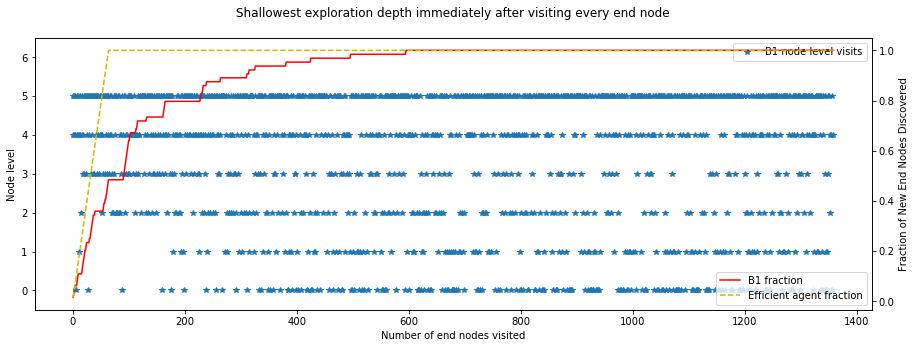

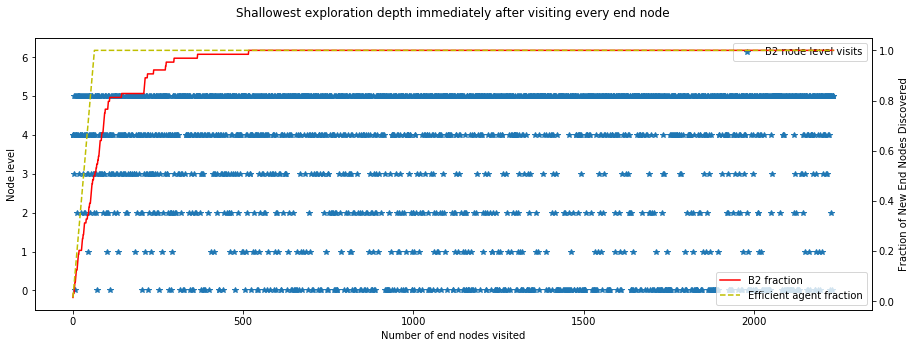

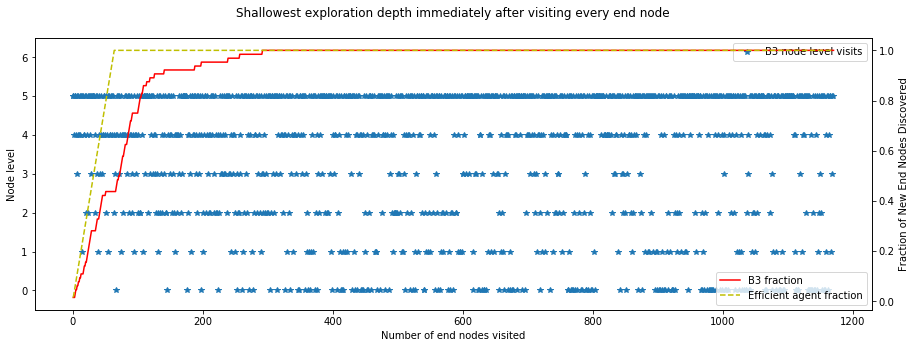

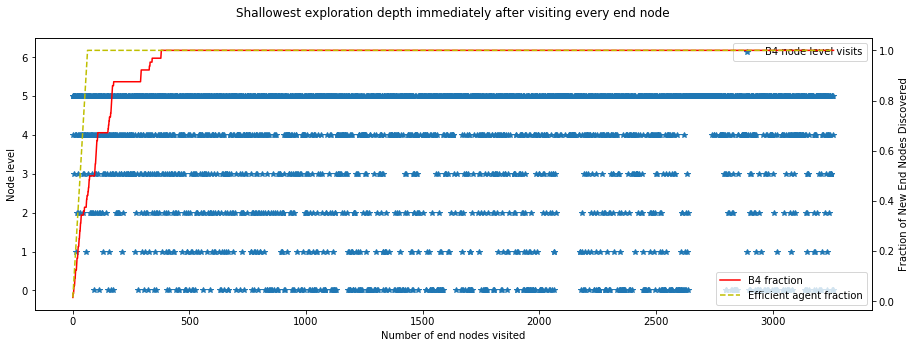

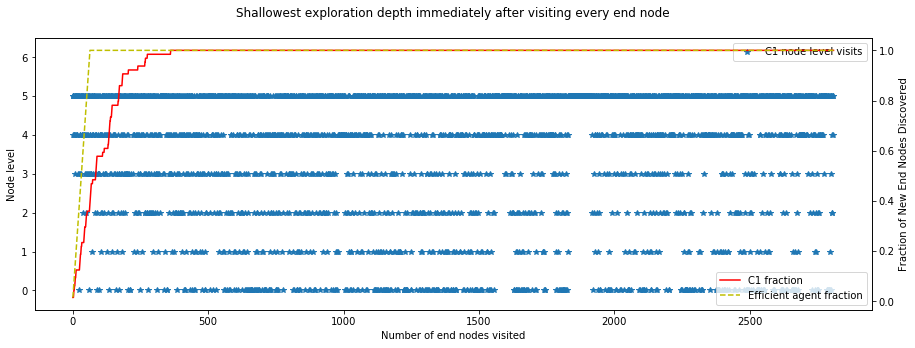

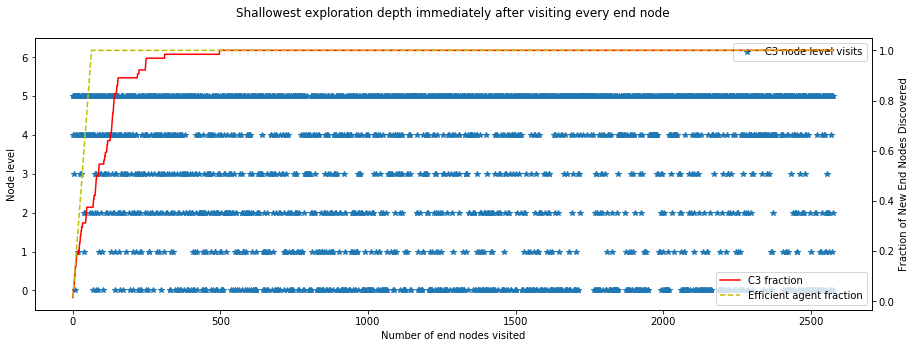

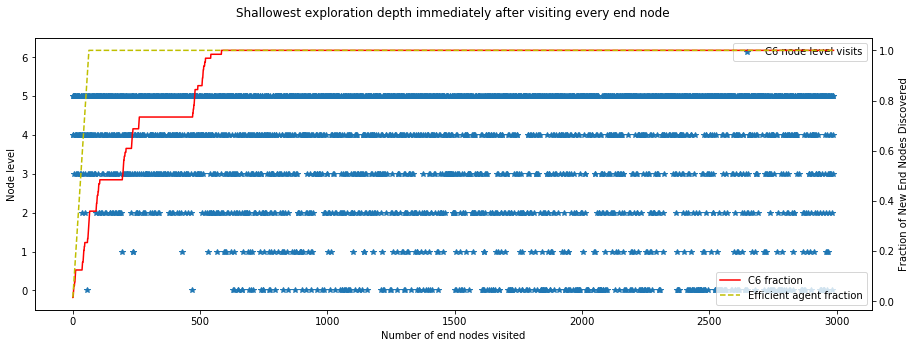

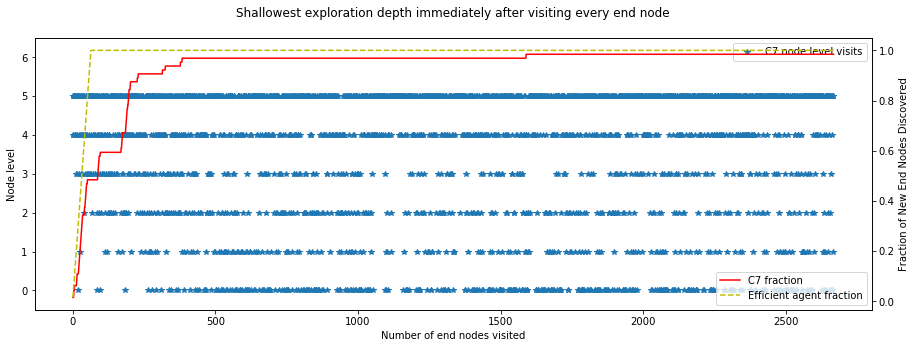

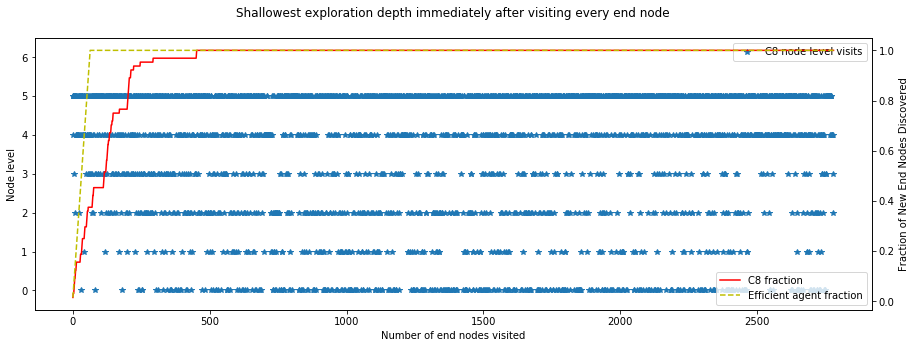

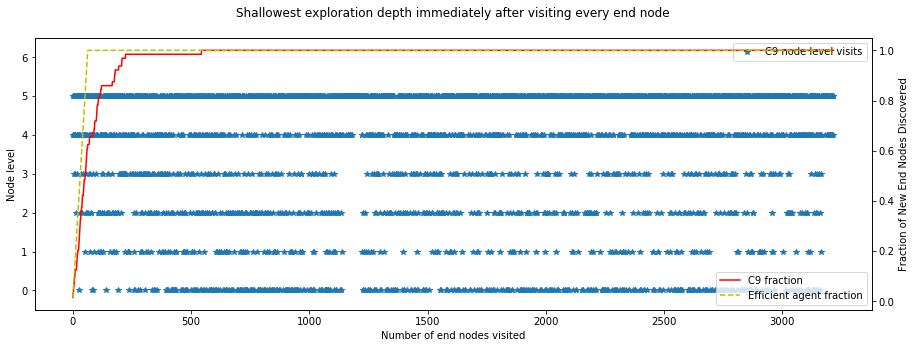

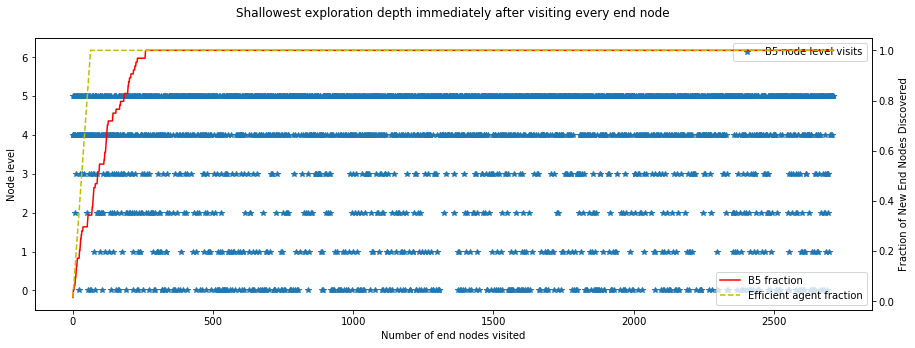

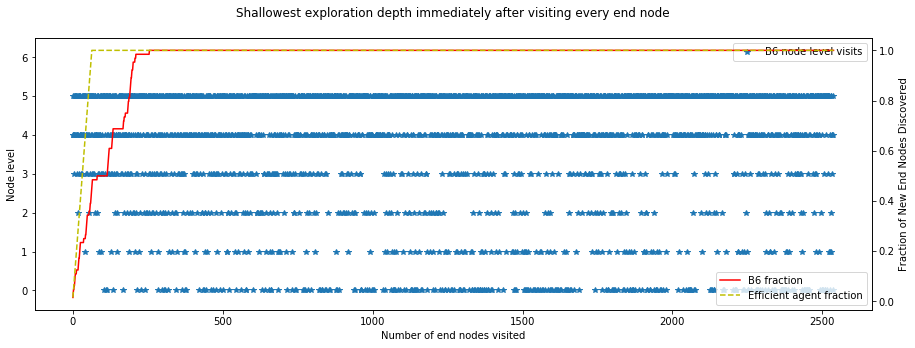

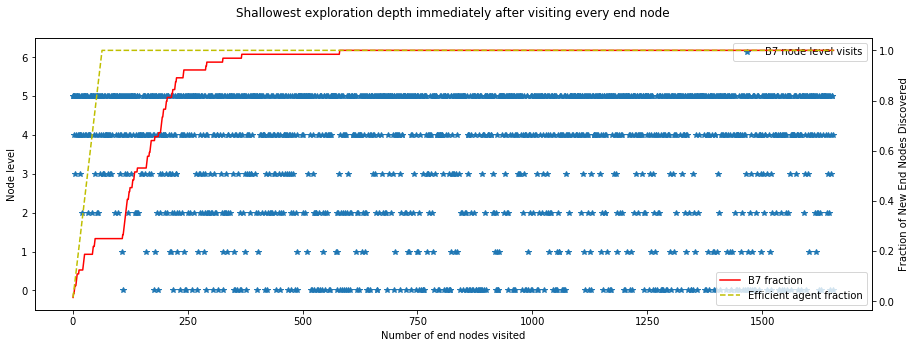

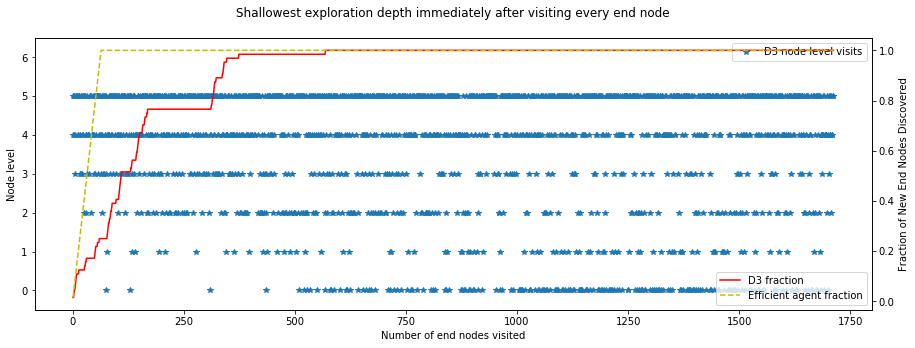

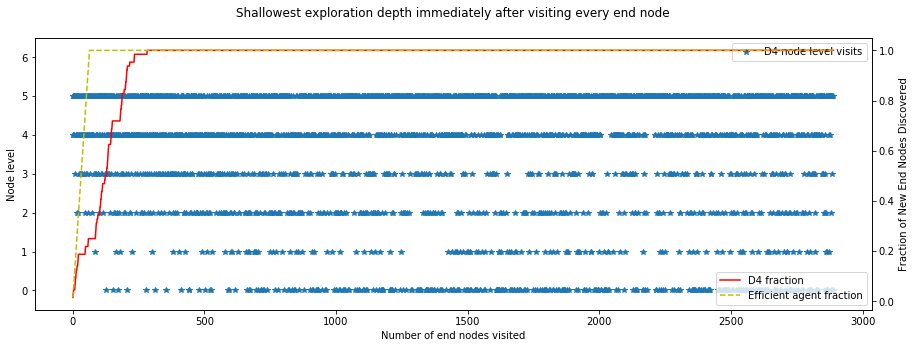

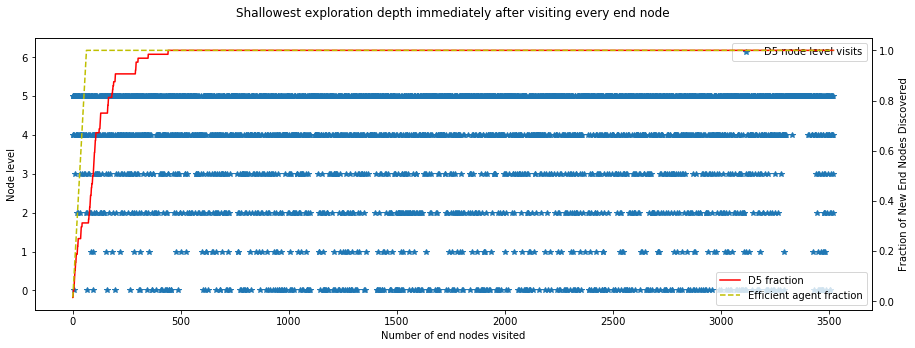

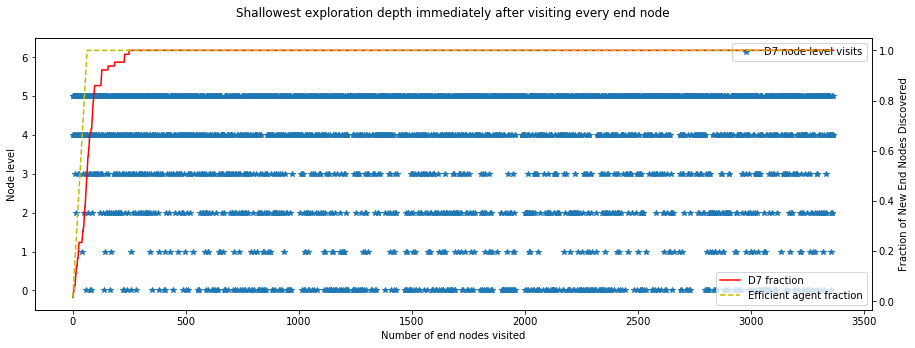

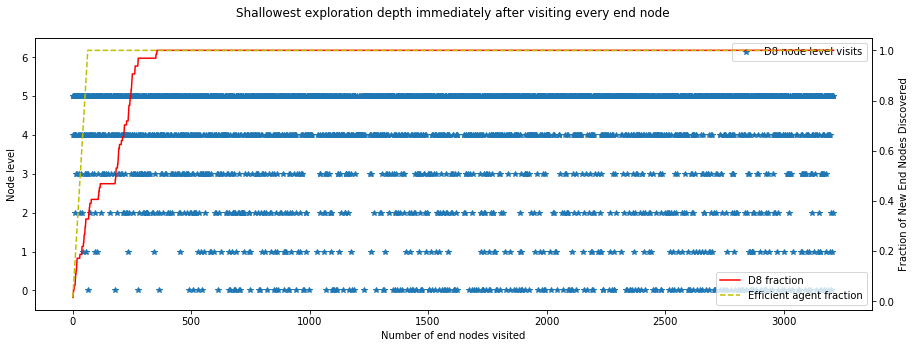

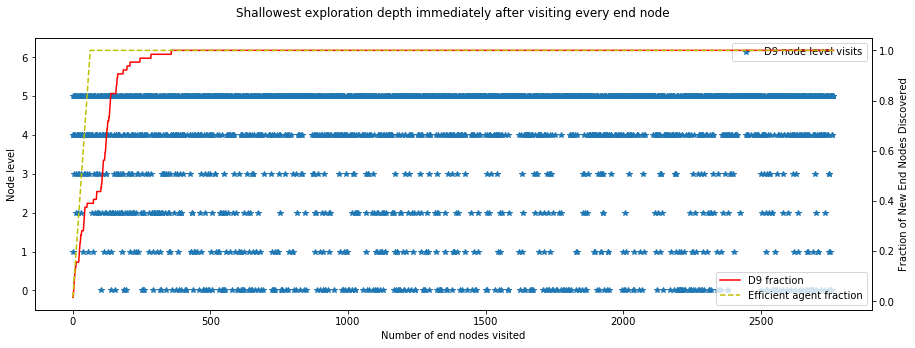

In [24]:
# Plot figure for shallowest level explored immediately after every end node visit
for mouseID, nickname in enumerate(AllNames):
    if nickname != 'D6':
        fig, ax1 = plt.subplots(figsize=[15,5])
        shallow_nodes = [val[1] for val in nxEN[mouseID]]
        eff_agent = list(np.cumsum([1]*64))
        eff_agent.extend([64]*(len(shallow_nodes)-64))
        ax1.plot(np.arange(len(shallow_nodes)), shallow_nodes, '*', label=nickname+' node level visits')
        ax1.set_ylim([-0.5,6.5])
        ax1.set_ylabel('Node level')
        ax1.set_xlabel('Number of end nodes visited')
        ax1.set_title('Shallowest exploration depth immediately after visiting every end node\n')
        
        ax2 = ax1.twinx() 
        #ax2.plot(np.arange(1,len(shallow_nodes)+1), eff_agent/np.arange(1,len(shallow_nodes)+1), '--y', label='Efficient agent fraction')
        ax2.plot(np.arange(1,len(shallow_nodes)+1), node_eff[mouseID], 'r', label=nickname+' fraction')
        ax2.plot(np.arange(1,len(shallow_nodes)+1), eff_agent/np.array([64]*len(eff_agent)), '--y', label='Efficient agent fraction')
        ax2.set_ylabel('Fraction of New End Nodes Discovered')
        ax1.legend()
        ax2.legend(loc='lower right')
        

Text(0.5, 1.0, 'Average fraction of shallowest nodes reached after visiting every end node\n')

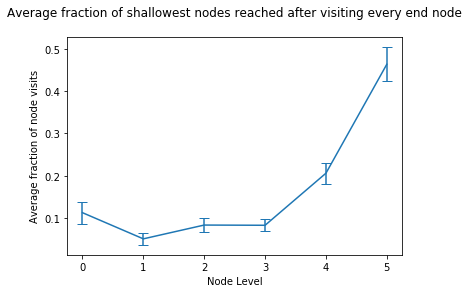

In [19]:
# Summary of the average number of shallowest nodes reached after visiting an end node 
node_list = np.zeros((6,20))
for mouseID, nickname in enumerate(AllNames):
    shallow_nodes = [val[1] for val in nxEN[mouseID]]
    for node in shallow_nodes:
        node_list[node, mouseID] += 1
node_list[node_list==0] = np.nan
total_nodes = np.sum(node_list, axis=0)
node_frac = [node_list[i,:]/total_nodes for i in np.arange(6)]
avg_node_list = np.nanmean(node_frac,axis=1)
std_node_list = np.nanstd(node_frac,axis=1)
node_count = [len(val) for val in lvl_dict.values()]

plt.figure()
plt.errorbar(np.arange(0,6), avg_node_list, yerr=std_node_list, capsize=5)
plt.xlabel('Node Level')
plt.ylabel('Average fraction of node visits')
plt.title('Average fraction of shallowest nodes reached after visiting every end node\n')